In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
%cd /content/drive/MyDrive/StatisticalLearningTheoryTeamProject

/content/drive/MyDrive/StatisticalLearningTheoryTeamProject


In [61]:
import os
from glob import glob
from typing import Tuple, Sequence, Callable
import random

import numpy as np
import pandas as pd

import PIL
from PIL import Image
from matplotlib.pyplot import imshow

import torch
import torch.optim as optim
from torch import nn, Tensor
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install torchinfo
from torchinfo import summary

import torchvision
from torchvision import transforms
from torchvision.models import resnet50

from tqdm import tqdm, tqdm_notebook


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets


In [62]:
pwd

'/content/drive/MyDrive/StatisticalLearningTheoryTeamProject'

In [63]:
# 데이터 경로 설정

path = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/'

batch_size = 32
num_epochs = 20
learning_rate = 0.001

labels = {"circular_alopecia": 0, "keratosis": 1,
          "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}



train = pd.read_csv(path + 'train_source.csv')
valid = pd.read_csv(path + 'val_source.csv')
test = pd.read_csv(path + 'test_source.csv')

train.head()



,filename,width,height,class,xmin,ymin,xmax,ymax
0,nasal_discharge_00000752_jpg.rf.85793634f22462...,300,300,nasal_discharge,53,108,87,148
1,conjunctival_injection_or_redness_00000867_jpg...,300,300,conjunctival_injection_or_redness,127,119,161,167
2,circular_alopecia_00000268_jpg.rf.85869ce3b855...,296,296,circular_alopecia,107,78,145,145
3,nasal_discharge_00000267_jpg.rf.858e63af6a0e91...,300,300,nasal_discharge,56,152,145,216
4,skin_lesions_00000917_jpg.rf.859254a3e97cd5fb6...,300,300,skin_lesions,158,150,299,277


In [9]:
'''
# gpu 사용중일땐 cuda, gpu 사용 불가능할땐 cpu 사용.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)
'''

"\n# gpu 사용중일땐 cuda, gpu 사용 불가능할땐 cpu 사용.\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\ntorch.manual_seed(777)\nif device =='cuda':\n    torch.cuda.manual_seed_all(777)\n"

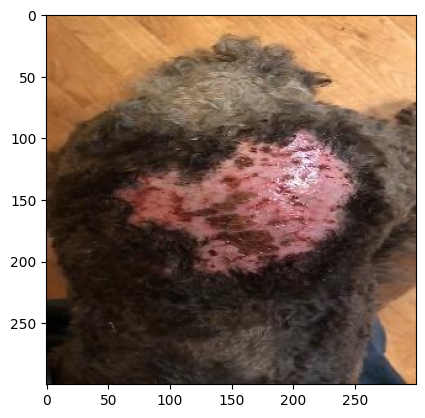

In [64]:
# 이미지 확인


img = Image.open(path + 'train/skin_lesions_00000999_jpg.rf.c0731ac2275a98f20569291f8ad92967.jpg')
imshow(np.asarray(img))

In [11]:
# # 원-핫 인코딩

# df = pd.DataFrame({'disease':['circular_alopecia','keratosis','skin_lesions','nasal_discharge','ocular_discharge',
#             'conjunctival_injection_or_redness']})

# pd.get_dummies(df)

In [65]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    # 1.
    def __init__(self, df, img_dir, transform=None, is_test=False):
        super().__init__() # 상속받은 Dataset의 __init__() 메서드 호출
        # 전달받은 인수 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋 크기 반환 메서드
    def __len__(self):
        return len(self.df)

    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]             # 이미지 ID
        img_path = self.img_dir + img_id  # 2. 이미지 파일 경로
        image = cv2.imread(img_path)  # 이미지 파일 읽기
        if image is None:
            print("이미지 로드 오류")
            return None
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        # 이미지 변환
        if self.transform is not None:
            image = self.transform(image=image)['image']  # 3.
        # 테스트 데이터면 이미지 데이터만 반환, 그렇지 않으면 타깃값도 반환
        if self.is_test:  # 4.
            return image # 5. 테스트용일 때
        else:
            # 타깃값 8개 중 가장 큰 값의 인덱스  # 6.
            label_idx = self.df.iloc[idx, 3]

            if label_idx is None:
              print("label 오류")
              return None
            label_mapping = {"circular_alopecia": 0, "keratosis": 1, "skin_lesions": 2, "nasal_discharge": 3, "ocular_discharge": 4, "conjunctival_injection_or_redness": 5}
            label = label_mapping[label_idx]
            label_tensor = torch.tensor(label, dtype=torch.long) ##
            # print(label_tensor)
            return image, label_tensor # 훈련/검증용일 때  # 7.




In [66]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [49]:
# 훈련 데이터용 변환기
transform_train = A.Compose([
    A.Resize(300, 300),       # 1. 이미지 크기 조절
    # A.RandomBrightnessContrast(brightness_limit=0.2, # 2. 밝기 대비 조절
    #                            contrast_limit=0.2, p=0.3),
    # A.VerticalFlip(p = 0.2),    # 상하 대칭 변환
    # A.HorizontalFlip(p = 0.5),  # 좌우 대칭 변환
    # A.ShiftScaleRotate(       # 3. 이동, 스케일링, 회전 변환
    #     shift_limit = 0.1,
    #     scale_limit = 0.2,
    #     rotate_limit = 30, p = 0.3),
    # A.OneOf([A.Emboss(p = 1),   # 4. 양각화, 날카로움, 블러 효과
    #          A.Sharpen(p = 1),
    #          A.Blur(p = 1)], p = 0.3),
    # A.PiecewiseAffine(p = 0.3), # 5. 어파인 변환
    A.Normalize(),            # 6. 정규화 변환
    ToTensorV2()              # 7. 텐서로 변환
])

In [67]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([
    A.Resize(300, 300), # 이미지 크기 조절
    A.Normalize(),      # 정규화 변환
    ToTensorV2()        # 텐서로 변환
])

In [68]:
train_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/train/'
val_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/valid/'


dataset_train = ImageDataset(train, img_dir=train_img_dir, transform=transform_train)
dataset_valid = ImageDataset(valid, img_dir=val_img_dir, transform=transform_test)


In [69]:
def seed_worker(worker_id):   #데이터 로더 시드값 고정 함수
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()  # 제너레이터 생성
g.manual_seed(0)  # 제너레이터 시드값 고정

In [70]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 2 ##

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle=True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)
loader_valid = DataLoader(dataset_valid, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

# Train Skin Lesion Segmentation

In [19]:
''' #기존유넷

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.n_classes = out_channels
        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = [
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            ]
            return nn.Sequential(*layers)

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=in_channels, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)


        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)




        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, output_padding=1, bias=True)

        self.dec4_2 = CBR2d(in_channels=2*512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0,output_padding=1, bias=True)

        self.dec3_2 = CBR2d(in_channels=2*256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2*128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2*64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=self.n_classes, kernel_size=1, stride=1, padding=0, bias=True)
        # self.fc = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=1, stride=1, padding=0, bias=True)


    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        #print("이엔씨11", enc1_1.size())
        enc1_2 = self.enc1_2(enc1_1)
        #print("이엔씨12", enc1_2.size())
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        #print("이엔씨21", enc2_1.size())
        enc2_2 = self.enc2_2(enc2_1)
        #print("이엔씨22", enc2_2.size())
        pool2 = self.pool2(enc2_2)
        #print("풀2", pool2.size())

        enc3_1 = self.enc3_1(pool2)
        #print("이엔씨31", enc3_1.size())
        enc3_2 = self.enc3_2(enc3_1)
        #print("이엔씨32", enc3_2.size())
        pool3 = self.pool3(enc3_2)
        #print("풀3", pool3.size())

        enc4_1 = self.enc4_1(pool3)
        #print("이엔씨41", enc4_1.size())
        enc4_2 = self.enc4_2(enc4_1)
        #print("이엔씨42", enc4_2.size())

        pool4 = self.pool4(enc4_2)
        #print("풀4", pool4.size())

        enc5_1 = self.enc5_1(pool4)
        #print("이엔씨51", enc5_1.size())



        dec5_1 = self.dec5_1(enc5_1)
        #print("덱51", dec5_1.size())

        unpool4 = self.unpool4(dec5_1)
        #print("언풀4", unpool4.size())
        #print("이엔씨42", enc4_2.size())
        cat4 = torch.cat((unpool4, enc4_2), dim=1)

        #print("Size of cat4:", cat4.size())
        # cat4 = torch.cat((unpool4, enc4_2), dim=1)[:,:,:unpool4.size(2), :unpool4.size(3)]  # 차원 1을 제외한 나머지 차원에서 크기 일치
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x
###


'''

' #기존유넷\n\n## 네트워크 구축하기\nclass UNet(nn.Module):\n    def __init__(self, in_channels, out_channels):\n        super(UNet, self).__init__()\n        self.n_classes = out_channels\n        # Convolution + BatchNormalization + Relu 정의하기\n        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):\n            layers = [\n                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,\n                          kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),\n                nn.BatchNorm2d(num_features=out_channels),\n                nn.ReLU()\n            ]\n            return nn.Sequential(*layers)\n\n        # 수축 경로(Contracting path)\n        self.enc1_1 = CBR2d(in_channels=in_channels, out_channels=64)\n        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)\n\n        self.pool1 = nn.MaxPool2d(kernel_size=2)\n\n        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)\n        self.enc2_2 = CBR2d(in_channels=1

In [71]:
#1130유넷 수정
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.n_classes = out_channels
        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = [
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                          kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU()
            ]
            return nn.Sequential(*layers)

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=in_channels, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)


        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)




        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, output_padding=1, bias=True)

        self.dec4_2 = CBR2d(in_channels=2*512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0,output_padding=1, bias=True)

        self.dec3_2 = CBR2d(in_channels=2*256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2*128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2*64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        #self.fc = nn.Conv2d(in_channels=64, out_channels=self.n_classes, kernel_size=1, stride=1, padding=0, bias=True)
        self.fc = nn.Linear(in_features=64, out_features=self.n_classes)

    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        #print("이엔씨11", enc1_1.size())
        enc1_2 = self.enc1_2(enc1_1)
        #print("이엔씨12", enc1_2.size())
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        #print("이엔씨21", enc2_1.size())
        enc2_2 = self.enc2_2(enc2_1)
        #print("이엔씨22", enc2_2.size())
        pool2 = self.pool2(enc2_2)
        #print("풀2", pool2.size())

        enc3_1 = self.enc3_1(pool2)
        #print("이엔씨31", enc3_1.size())
        enc3_2 = self.enc3_2(enc3_1)
        #print("이엔씨32", enc3_2.size())
        pool3 = self.pool3(enc3_2)
        #print("풀3", pool3.size())

        enc4_1 = self.enc4_1(pool3)
        #print("이엔씨41", enc4_1.size())
        enc4_2 = self.enc4_2(enc4_1)
        #print("이엔씨42", enc4_2.size())

        pool4 = self.pool4(enc4_2)
        #print("풀4", pool4.size())

        enc5_1 = self.enc5_1(pool4)
        #print("이엔씨51", enc5_1.size())



        dec5_1 = self.dec5_1(enc5_1)
        #print("덱51", dec5_1.size())

        unpool4 = self.unpool4(dec5_1)
        #print("언풀4", unpool4.size())
        #print("이엔씨42", enc4_2.size())
        cat4 = torch.cat((unpool4, enc4_2), dim=1)

        #print("Size of cat4:", cat4.size())
        #cat4 = torch.cat((unpool4, enc4_2), dim=1)[:,:,:unpool4.size(2), :unpool4.size(3)]  # 차원 1을 제외한 나머지 차원에서 크기 일치
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x
###




In [72]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

In [73]:


# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 2 ##
num_epoch = 20

base_dir = path
# data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 3
n_classes = 6  # 예를 들면, 여기서 6개의 클래스로 분류하려 한다면
model = UNet(in_channels = in_channels, out_channels=n_classes)  # n_classes 매개변수를 전달하여 UNet 모델 초기화
model = model.to(device)





# 손실함수 정의하기
fn_loss = nn.CrossEntropyLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(model.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_valid)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)




# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))





In [74]:
# print(images)

In [75]:
 # 1130수정코드
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

epochs = 5

# 총 에폭만큼 반복
for epoch in range(epochs):
    # <훈련>
    model.train()        # 모델을 훈련 상태로 설정
    epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)




    # '반복 횟수'만큼 반복
    for images, labels in tqdm(loader_train):

      ###
        # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
        #labels = torch.tensor([0, 1, 2, 3, 4, 5]) ###
        # labels = torch.zeros(images, len(labels), 300, 300)   ##
        # 6개의 클래스에 대한 바이너리 마스크로 변환합니다.
        num_classes = 6
        #batch_size = labels.size(0)  # 배치 크기
        batch_size = 2 ##

        #labels = labels.to(device)


        height, width = 300, 300  # 이미지의 높이와 너비 (300으로 가정)
        target = torch.zeros(batch_size, num_classes, height, width)



        #1128수정
        for i in range(batch_size):
            # 각 픽셀에 대해 해당 클래스의 인덱스 위치에 1로 설정합니다.
            label_idx = labels[i].item()
            target[i, label_idx, :, :] = 1
            target = torch.zeros(batch_size, num_classes, height, width)


        # image, labels = Dataset.__getitem__(idx=label_idx) ###
        images = images.to(device)
        labels = labels.to(device)
        #labels = torch.tensor(labels) ###
        labels = torch.tensor(labels, dtype=torch.long)

        # 옵티마이저 내 기울기 초기화
        optim.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산

        #loss = fn_loss(outputs, target)
        loss = nn.MSELoss()(outputs, labels)
        # 현재 배치에서의 손실 추가 (훈련 데이터용)
        epoch_train_loss += loss.item()
        loss.backward() # 역전파 수행
        optim.step() # 가중치 갱신
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 훈련 데이터 손실값 : {epoch_train_loss/len(loader_train):.4f}')

    # <검증>
    model.eval()          # 모델을 평가 상태로 설정
    epoch_valid_loss = 0  # 에폭별 손실값 초기화 (검증 데이터용)
    preds_list = []       # 예측 확률값 저장용 리스트 초기화
    true_onehot_list = [] # 실제 타깃값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성화
        # 미니배치 단위로 검증
        for images, labels in loader_valid:
            images = images.to(device)
            labels = labels.to(device)
            labels = torch.tensor(labels, dtype=torch.long)

            outputs = model(images)
            loss = fn_loss(outputs, labels)
            epoch_valid_loss += loss.item()

            preds = torch.softmax(outputs.cpu(), dim=1).numpy() # 예측 확률값
            # 실제값 (원-핫 인코딩 형식)
            true_onehot = torch.eye(6)[labels].cpu().numpy()
            # 예측 확률값과 실제값 저장
            preds_list.extend(preds)
            true_onehot_list.extend(true_onehot)
    # 검증 데이터 손실값 및 ROC AUC 점수 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 검증 데이터 손실 값 : {epoch_valid_loss/len(loader_valid):.4f} / 검증 데이터 ROC AUC : {roc_auc_score(true_onehot_list, preds_list):.4f}')



  0%|          | 0/7199 [00:00<?, ?it/s]

<ipython-input-75-418fd736faf6>:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.long)


RuntimeError: ignored

In [31]:

from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수
from tqdm.notebook import tqdm # 진행률 표시 막대

# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
model, optim, st_epoch = load(ckpt_dir=ckpt_dir, model=model, optim=optim)

for epoch in range(st_epoch + 1, num_epoch + 1):
        model.train()
        loss_arr = []

        #for batch, data in enumerate(loader_train, 1):
        for images, labels in enumerate(loader_train):
            # forward pass
            #label = data['label'].to(device)
            #input = data['input'].to(device)
            #images = images.to(device)
            #labels = labels.to(device)

            #output = net(input)
            output = model(images)
            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            model_statistics.eval()
            loss_arr = []

            for batch, data in enumerate(loader_valid, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = model(images)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, model=model, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()



'''

SyntaxError: ignored

In [ ]:
'''


transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

'''

In [ ]:
test_img_dir = '/content/drive/MyDrive/StatisticalLearningTheoryTeamProject/test/'


dataset_test = ImageDataset(train, img_dir=test_img_dir, transform=transform_test)








from torch.utils.data import DataLoader # 데이터 로더 클래스

batch_size = 2 ##

loader_test = DataLoader(dataset_test, batch_size=batch_size,
                          shuffle=False, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

In [ ]:
model.eval() # 모델을 평가 상태로 설정

preds = np.zeros((len(test), 4)) # 예측값 저장용 배열 초기화

with torch.no_grad():
    for i, images in enumerate(loader_test):
        images = images.to(device)
        outputs = model(images)
        # 타깃 예측 확률
        preds_part = torch.softmax(outputs.cpu(), dim=1).squeeze().numpy()
        preds[i*batch_size:(i+1)*batch_size] += preds_part

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()